In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dropout,Dense, Flatten, BatchNormalization, Conv2D, MaxPooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix
import itertools
from keras.models import load_model
import os
import shutil
from keras import backend as K
import random
import glob
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
%matplotlib inline

In [2]:
img_width, img_height = 150, 150

train_data_dir = '../input/binary-wbc/binary_data/train'
validation_data_dir = '../input/binary-wbc/binary_data/validation'
test_data_dir = '../input/binary-wbc/binary_data/test'
nb_train_samples = 9920
nb_validation_samples = 2083
epochs = 25
batch_size = 64

if K.image_data_format() == 'channels_first':
    input_shape = (3, img_width, img_height)
else:
    input_shape = (img_width, img_height, 3)

In [3]:
train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)
test_datagen = ImageDataGenerator(rescale=1. / 255)


In [4]:
train_batches = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    classes=['MONONUCLEAR', 'POLYNUCLEAR'])
    #color_mode="grayscale")

Found 9920 images belonging to 2 classes.


In [5]:
valid_batches = test_datagen.flow_from_directory(
    validation_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    classes=['MONONUCLEAR', 'POLYNUCLEAR'])
    #color_mode="grayscale")

Found 2083 images belonging to 2 classes.


In [6]:
test_batches = test_datagen.flow_from_directory(
    test_data_dir,
    target_size=(img_width, img_height),
    batch_size=400,
    classes=['MONONUCLEAR', 'POLYNUCLEAR'])
    #color_mode="grayscale")

Found 400 images belonging to 2 classes.


In [7]:
#train_batches = ImageDataGenerator().flow_from_directory(directory=train_data_dir, target_size=(150,150), classes=['MONONUCLEAR', 'POLYNUCLEAR'], batch_size=batch_size)
#valid_batches = ImageDataGenerator().flow_from_directory(directory=validation_data_dir, target_size=(150,150), classes=['MONONUCLEAR', 'POLYNUCLEAR'], batch_size=batch_size)
#test_batches = ImageDataGenerator().flow_from_directory(directory=test_data_dir, target_size=(150,150), classes=['MONONUCLEAR', 'POLYNUCLEAR'], batch_size=400, shuffle=False)

In [8]:
def plots(ims, figsize=(12,6), rows=None, interp=False, titles=None):
    if type(ims[0]) is np.ndarray:
        ims = np.array(ims).astype(np.uint8)
        if (ims.shape[-1] != 3):
            ims = ims.transpose((0,2,3,1))
    f = plt.figure(figsize=figsize)
    cols = len(ims)//rows if len(ims) % 2 == 0 else len(ims)//rows +1
    for i in range(len(ims)):
        sp = f.add_subplot(rows, cols, i+1)
        sp.axis('Off')
        if titles is not None:
            sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i], interpolation=None if interp else 'none')

In [9]:
imgs, labels = next(train_batches)

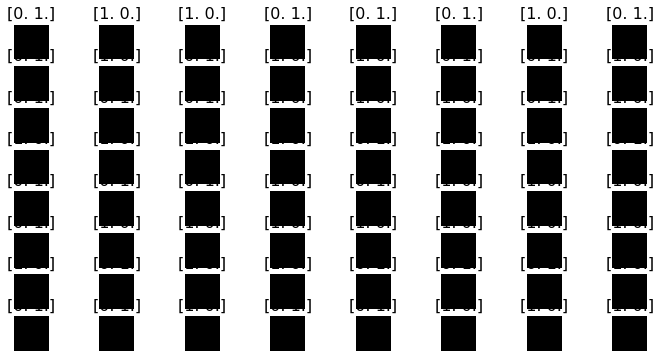

In [10]:
plots(imgs, rows=8, titles=labels)

In [11]:
model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=input_shape))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

In [12]:
model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

In [13]:
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

In [14]:
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

In [15]:
model.add(Conv2D(128, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

In [16]:
model.add(Flatten())
model.add(Dense(128))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(2))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])


In [17]:
%%time
h = model.fit_generator(
    train_batches,
    steps_per_epoch=nb_train_samples // batch_size,
    epochs=epochs,
    validation_data=valid_batches,
    validation_steps=nb_validation_samples // batch_size,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5),
        tf.keras.callbacks.ModelCheckpoint(filepath = '/kaggle/working/model_{val_accuracy:.3f}.h5', save_best_only=True,
                                          save_weights_only=False, monitor='val_accuracy')
    ])

Epoch 1/25
155/155 [==============================] - 72s 464ms/step - loss: 0.6993 - accuracy: 0.5007 - val_loss: 0.6932 - val_accuracy: 0.5020
Epoch 2/25
155/155 [==============================] - 65s 422ms/step - loss: 0.6936 - accuracy: 0.5017 - val_loss: 0.6932 - val_accuracy: 0.5005
Epoch 3/25
155/155 [==============================] - 65s 420ms/step - loss: 0.6931 - accuracy: 0.5001 - val_loss: 0.6825 - val_accuracy: 0.6245
Epoch 4/25
155/155 [==============================] - 65s 419ms/step - loss: 0.6746 - accuracy: 0.5841 - val_loss: 0.6895 - val_accuracy: 0.5283
Epoch 5/25
155/155 [==============================] - 65s 419ms/step - loss: 0.5892 - accuracy: 0.7013 - val_loss: 1.1350 - val_accuracy: 0.5024
Epoch 6/25
155/155 [==============================] - 65s 418ms/step - loss: 0.5208 - accuracy: 0.7577 - val_loss: 0.4098 - val_accuracy: 0.8413
Epoch 7/25
155/155 [==============================] - 65s 417ms/step - loss: 0.4068 - accuracy: 0.8223 - val_loss: 0.2477 - val_ac

In [18]:
test_imgs, test_labels = next(test_batches)
#plots(test_imgs, rows=50, titles=test_labels)

In [19]:
#test_labels = test_labels[:,0]
rounded_labels = np.argmax(test_labels, axis=-1)
#test_labels

In [20]:
test_model = load_model('./model_0.951.h5')

In [21]:
predictions = test_model.predict_generator(test_batches, steps=1, verbose=0)

In [22]:
predictions

array([[3.55930440e-03, 9.96440709e-01],
       [9.92977083e-01, 7.02286279e-03],
       [5.14460215e-03, 9.94855404e-01],
       [7.95040512e-04, 9.99204934e-01],
       [9.35932636e-01, 6.40673637e-02],
       [9.99887586e-01, 1.12456619e-04],
       [9.59588230e-01, 4.04118113e-02],
       [9.91381466e-01, 8.61848798e-03],
       [9.99667525e-01, 3.32434312e-04],
       [9.99993443e-01, 6.58468480e-06],
       [1.00324757e-01, 8.99675250e-01],
       [9.99995232e-01, 4.72001966e-06],
       [7.27866078e-03, 9.92721260e-01],
       [9.99884725e-01, 1.15263516e-04],
       [2.01948449e-01, 7.98051536e-01],
       [7.25140050e-02, 9.27486002e-01],
       [9.99770820e-01, 2.29130615e-04],
       [9.84911799e-01, 1.50882304e-02],
       [1.98013246e-01, 8.01986754e-01],
       [2.62005366e-02, 9.73799407e-01],
       [4.46932577e-02, 9.55306768e-01],
       [9.28236230e-04, 9.99071717e-01],
       [2.84221381e-01, 7.15778649e-01],
       [7.20647991e-01, 2.79352039e-01],
       [3.248133

In [23]:
rounded_prediction = np.argmax(predictions, axis=-1)

In [24]:
for i in rounded_prediction:
    print(i)

1
0
1
1
0
0
0
0
0
0
1
0
1
0
1
1
0
0
1
1
1
1
1
0
1
0
0
1
1
0
1
0
0
0
1
0
0
1
0
1
0
0
1
1
0
1
0
1
1
1
0
0
0
1
0
1
0
1
1
0
0
1
1
0
1
0
0
0
1
1
1
1
0
1
1
1
0
0
1
1
1
0
0
1
0
0
1
1
1
0
0
1
0
1
1
1
0
0
1
0
0
0
0
1
0
0
0
1
0
0
1
0
1
1
1
0
0
0
1
0
0
0
0
1
0
0
1
1
0
1
1
0
0
1
1
0
1
0
1
1
1
1
0
1
0
1
1
1
0
1
0
0
1
1
1
1
0
0
0
1
0
0
0
1
1
1
1
1
1
0
1
1
0
1
1
1
0
1
0
0
0
0
1
0
0
0
0
0
1
1
1
0
1
1
1
1
1
1
0
0
1
1
1
0
1
1
1
1
1
0
0
1
0
1
1
0
1
1
1
1
0
0
1
0
1
1
0
1
0
0
1
0
0
1
1
0
0
1
0
1
0
0
1
0
0
1
0
1
0
1
1
0
1
0
1
1
1
1
1
0
0
0
1
1
0
0
1
1
0
1
0
1
0
1
0
0
1
0
1
0
0
1
1
1
1
1
0
1
0
0
1
0
0
1
0
1
0
0
0
1
1
1
1
0
1
0
1
0
0
1
0
1
1
1
1
1
1
1
0
0
0
0
0
1
1
0
0
1
0
0
0
1
1
1
0
0
0
1
0
0
0
1
1
0
0
0
1
1
0
1
0
1
1
1
0
0
0
0
0
1
0
1
1
1
0
0
0
1
1
0
1
1
1
1
0
0
0
0
0
1
1
1
1
1
0
0
0
1
1
1
0
1
1
1
0
1
1
0
0
0


In [25]:
cm = confusion_matrix(y_true=rounded_labels, y_pred=rounded_prediction)

In [26]:
def plot_confusion_matrix(cm, classes,
                        normalize=False,
                        title='Confusion matrix',
                        cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[191   9]
 [  2 198]]


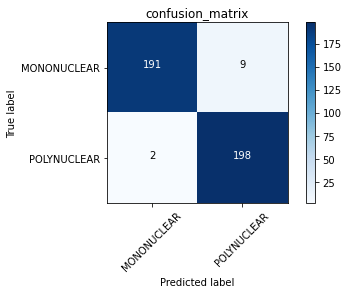

In [27]:
cm_plot_labels = ['MONONUCLEAR', 'POLYNUCLEAR']
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='confusion_matrix')

In [28]:
#confusion matrix-->correct identification = 198+191 = 389
#                -->wrong identification = 9+2 = 11
#                --> accuracy = 389/(389 + 11) = 0.9725 or (97.25% accuracy)

In [29]:
#from sklearn.metrics import classification_report

In [30]:
#print(classification_report(y_true=rounded_labels, y_pred=rounded_prediction))

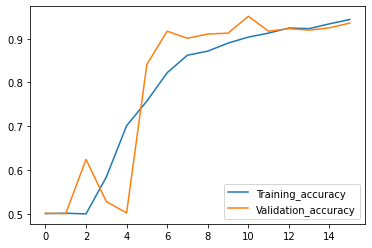

In [31]:
accs = h.history['accuracy']
val_accs = h.history['val_accuracy']

plt.plot(range(len(accs)),accs, label = 'Training_accuracy')
plt.plot(range(len(accs)),val_accs, label = 'Validation_accuracy')
plt.legend()
plt.show()

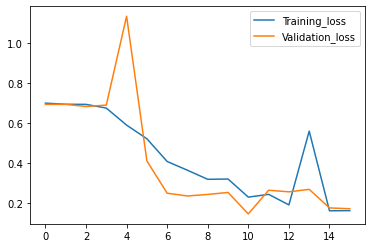

In [32]:
accs = h.history['loss']
val_accs = h.history['val_loss']

plt.plot(range(len(accs)),accs, label = 'Training_loss')
plt.plot(range(len(accs)),val_accs, label = 'Validation_loss')
plt.legend()
plt.show()